# Set up Data

In [4]:
!pip install -U gdown
import gdown

url="https://drive.google.com/file/d/1WEySXMFz6v1OgPkLKJ8QIp3Lk-eyTObY/view"
id="1WEySXMFz6v1OgPkLKJ8QIp3Lk-eyTObY"
gdown.download(f'https://drive.google.com/uc?id={id}', quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1WEySXMFz6v1OgPkLKJ8QIp3Lk-eyTObY
From (redirected): https://drive.google.com/uc?id=1WEySXMFz6v1OgPkLKJ8QIp3Lk-eyTObY&confirm=t&uuid=95f75b32-b628-44ec-9648-f5b4b40b3832
To: /content/Teeth DataSet.zip
100%|██████████| 49.1M/49.1M [00:00<00:00, 92.2MB/s]


'Teeth DataSet.zip'

In [5]:
import zipfile

with zipfile.ZipFile('/content/Teeth DataSet.zip', 'r') as zip_ref:
    zip_ref.extractall('Teeth_DataSet')

# Needed Libraries

In [19]:
!pip install gradio

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import glob
from PIL import Image
import cv2
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,Input,GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_input_efficientnet
from tensorflow.keras.optimizers import Adam
import gradio as gr


# Explore the Data

issus in the data:
* it contain images which is 4-Channel Image

In [7]:
img_size=224

In [8]:
train_dir="/content/Teeth_DataSet/Teeth_Dataset/Training"
test_dir="/content/Teeth_DataSet/Teeth_Dataset/Testing"
val_dir="/content/Teeth_DataSet/Teeth_Dataset/Validation"

In [9]:
class_names=os.listdir(val_dir)
class_names=sorted(class_names)
class_names
#['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']

['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']

Convert 4-Channel Images to 3 Channels

In [10]:
for folder in class_names:
  folder_path = glob.glob(train_dir + '/' + folder + '/*')
  for img_path in folder_path:
    img = plt.imread(img_path)
    if img.shape[-1] == 4:  # Image has 4 channels
      print(f"Deleting: {img_path}")
      os.remove(img_path)

Deleting: /content/Teeth_DataSet/Teeth_Dataset/Training/Gum/g_1207.jpg


In [11]:
for folder in class_names:
  folder_path = glob.glob(val_dir + '/' + folder + '/*')
  for img_path in folder_path:
    img = plt.imread(img_path)
    if img.shape[-1] == 4:  # Image has 4 channels
      print(f"Deleting: {img_path}")
      os.remove(img_path)

Deleting: /content/Teeth_DataSet/Teeth_Dataset/Validation/Gum/g_1208.jpg


In [12]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input_efficientnet,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input_efficientnet)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input_efficientnet)

In [13]:
train=train_gen.flow_from_directory(
    train_dir,
    target_size=(img_size,img_size),
    class_mode='categorical',
    batch_size=32,
    shuffle=True
)
test = test_gen.flow_from_directory(
    test_dir,
    target_size=(img_size,img_size),
    class_mode='categorical',
    classes=class_names,
    batch_size=32,
    shuffle=False   # IMPORTANT
)

val=val_gen.flow_from_directory(
    val_dir,
    target_size=(img_size,img_size),
    class_mode='categorical',
    batch_size=32
)

Found 3086 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Found 1027 images belonging to 7 classes.


In [14]:
print(train.class_indices)
print(val.class_indices)
print(test.class_indices)

{'CaS': 0, 'CoS': 1, 'Gum': 2, 'MC': 3, 'OC': 4, 'OLP': 5, 'OT': 6}
{'CaS': 0, 'CoS': 1, 'Gum': 2, 'MC': 3, 'OC': 4, 'OLP': 5, 'OT': 6}
{'CaS': 0, 'CoS': 1, 'Gum': 2, 'MC': 3, 'OC': 4, 'OLP': 5, 'OT': 6}


In [15]:
len(train)

97

In [16]:
class_labels = {v: k for k, v in train.class_indices.items()}  # Reverse the  dictionary
class_labels

{0: 'CaS', 1: 'CoS', 2: 'Gum', 3: 'MC', 4: 'OC', 5: 'OLP', 6: 'OT'}

# Modeling

## EfficientNet

* Designed to be efficient and accurate, especially on medical images.
* Achieves high performance with fewer parameters, which is helpful when you don’t have millions of teeth images.

When you're working with pre-trained models like EfficientNet, ResNet, or DenseNet, it's better to use GlobalAveragePooling2D rather than Flatten for these key reasons:<br>

1- GlobalAveragePooling reduces overfitting:
GlobalAveragePooling2D() just takes the average of each feature map, reducing it to one value per map.

2- GlobalAveragePooling captures spatial meaning better:
Instead of memorizing exact pixel locations like Flatten() might encourage, GlobalAveragePooling2D() summarizes the presence of features across the entire image.<br>
Teeth disease classification (we care if the disease appears, not where exactly on the image).


In [ ]:
"""
base_model is the EfficientNet without the top classification layer (because you used include_top=False).
Its output is typically a 4D tensor (batch size, height, width, channels) representing the feature maps extracted from the input image.
So you're saying:
“Hey, take whatever features EfficientNet learned and let’s continue building from there.”
"""
base = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(img_size, img_size, 3))
base.trainable = True
for layer in base.layers[:-20]:  # unfreeze only top 20 layers
    layer.trainable = False

x = base.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
# x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)

predictions = Dense(7, activation='softmax')(x)
model = Model(inputs=base.input, outputs=predictions)

In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [3]:
from google.colab import drive
drive.mount('/content/drive')
# Define the path in Google Drive where you want to save the model
save_path = "/content/drive/MyDrive/pretrained/efficient.keras"  # Replace "your_folder" with your desired path

Mounted at /content/drive


In [ ]:
# Compile the model
optimizer = Adam(learning_rate=1e-4 )

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

lr_schedul = ReduceLROnPlateau(
    monitor='val_loss',
    patience=2,
    verbose=1,
    factor=0.2,
    min_lr=1e-8
)

checkpoint = ModelCheckpoint(
    save_path,  # Save to Google Drive
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    verbose=1
)

# TensorBoard callback
log_dir = "logs/fit"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


In [ ]:
history = model.fit(
    train,
    validation_data=val,
    epochs=60,
    callbacks=[early_stopping, lr_schedul, checkpoint, tensorboard_callback]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/60
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3025 - loss: 1.8254
Epoch 1: val_loss improved from inf to 1.23975, saving model to /content/drive/MyDrive/pretrained/efficient.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 411s 4s/step - accuracy: 0.3036 - loss: 1.8236 - val_accuracy: 0.5501 - val_loss: 1.2397 - learning_rate: 1.0000e-04
Epoch 2/60
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6363 - loss: 1.1072
Epoch 2: val_loss improved from 1.23975 to 0.67342, saving model to /content/drive/MyDrive/pretrained/efficient.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 372s 4s/step - accuracy: 0.6367 - loss: 1.1061 - val_accuracy: 0.7868 - val_loss: 0.6734 - learning_rate: 1.0000e-04
Epoch 3/60
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7985 - loss: 0.6856
Epoch 3: val_loss improved from 0.67342 to 0.39663, saving model to /content/drive/MyDrive/pretrained/efficient.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 383s 4s/step - accuracy: 0.7986 - loss: 0.6851 - val_accuracy: 0.8832 - val_loss: 0.39

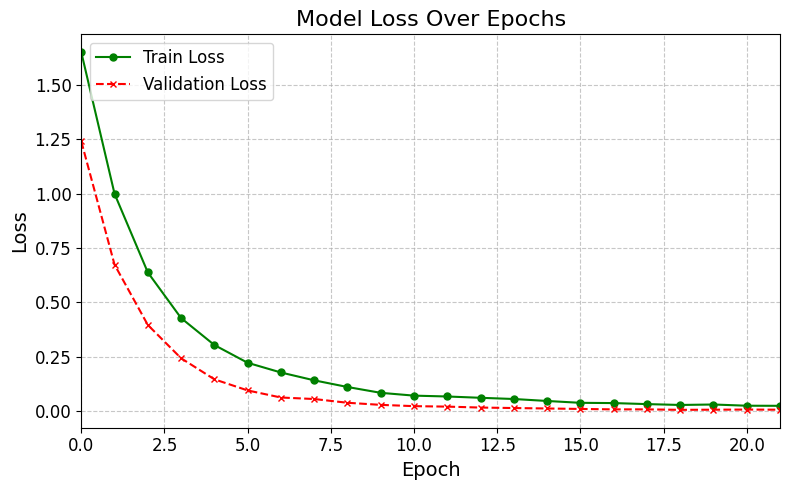

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], color='green', linestyle='-', marker='o', markersize=5, label='Train Loss')
plt.plot(history.history['val_loss'], color='red', linestyle='--', marker='x', markersize=5, label='Validation Loss')

plt.title('Model Loss Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)

plt.legend(loc='upper left', fontsize=12)

plt.xlim(0, len(history.history['loss']) - 1)

plt.tight_layout()
plt.show()


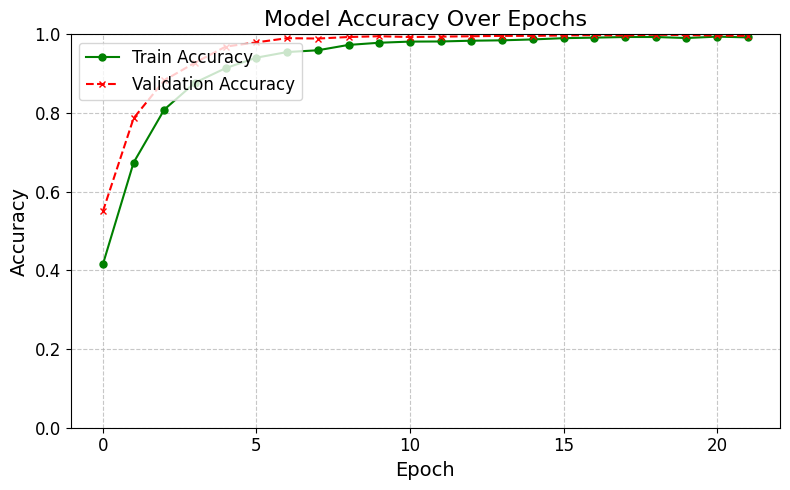

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], color='green', linestyle='-', marker='o', markersize=5, label='Train Accuracy')
plt.plot(history.history['val_accuracy'], color='red', linestyle='--', marker='x', markersize=5, label='Validation Accuracy')

plt.title('Model Accuracy Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)

plt.legend(loc='upper left', fontsize=12)

plt.ylim(0, 1)

plt.tight_layout()
plt.show()


# Load Model

In [17]:
# Load the model
loaded_model = load_model(save_path)

# Verify the model is loaded correctly (optional)
loaded_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_6         │ (None, 224, 224,  │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_3     │ (None, 224, 224,  │          7 │ rescaling_6[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_7         │ (None, 224, 224,  │          0 │ normalization_3[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_7[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 7,269,530 (27.73 MB)

 Trainable params: 1,523,639 (5.81 MB)

 Non-trainable params: 2,698,611 (10.29 MB)

 Optimizer params: 3,047,280 (11.62 MB)

# Model Evaluation

In [ ]:
loaded_model.evaluate(val)

33/33 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9996 - loss: 0.0050


[0.006848032120615244, 0.9990262985229492]

In [ ]:
loaded_model.evaluate(test)

33/33 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.9977 - loss: 0.0074


[0.012936647981405258, 0.9961089491844177]

In [ ]:
# Get true labels (y_true)
y_true = test.classes  # Ground truth labels (integers)

# Get model predictions (y_pred)
y_pred_probs = loaded_model.predict(test)  # Predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class indices

33/33 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step


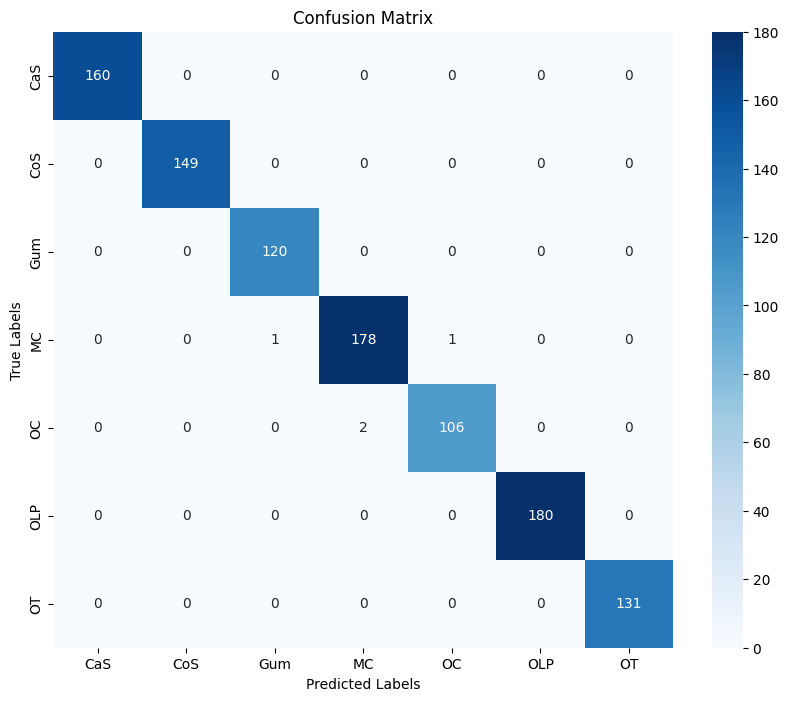

In [ ]:
# Get class names (same order as in the generator)
class_names = list(test.class_indices.keys())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

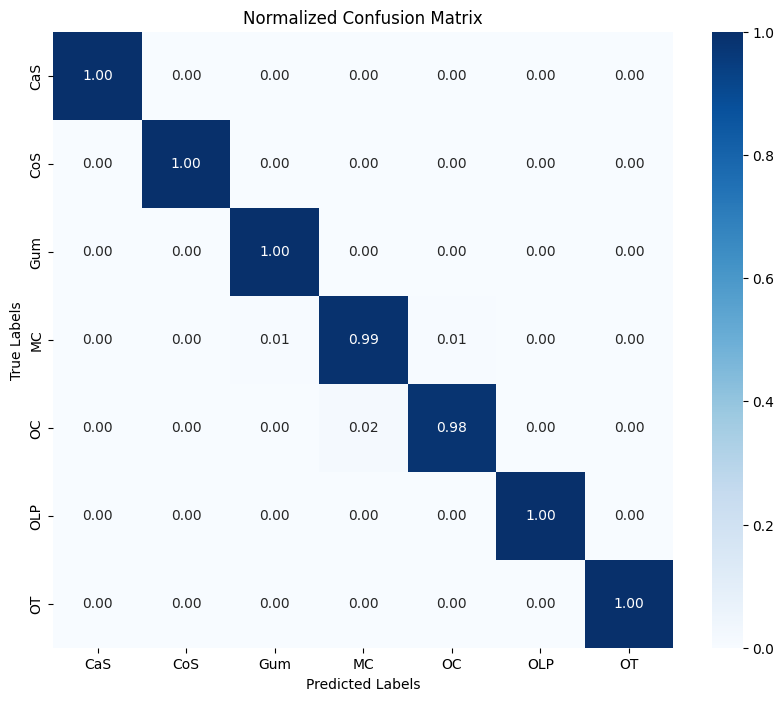

In [ ]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize by row (true labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

         CaS       1.00      1.00      1.00       160
         CoS       1.00      1.00      1.00       149
         Gum       0.99      1.00      1.00       120
          MC       0.99      0.99      0.99       180
          OC       0.99      0.98      0.99       108
         OLP       1.00      1.00      1.00       180
          OT       1.00      1.00      1.00       131

    accuracy                           1.00      1028
   macro avg       1.00      1.00      1.00      1028
weighted avg       1.00      1.00      1.00      1028



In [ ]:
# Get true labels (one-hot encoded)
y_true_onehot = []  # Store all batches
for i in range(len(test)):
    _, labels = test[i]
    y_true_onehot.append(labels)
y_true_onehot = np.concatenate(y_true_onehot)  # Shape: (n_samples, n_classes)

# Get predicted probabilities
y_pred_probs = loaded_model.predict(test)  # Shape: (n_samples, n_classes)

n_classes = y_true_onehot.shape[1]  # Number of classes
fpr = dict()  # False Positive Rate
tpr = dict()  # True Positive Rate
roc_auc = dict()  # Area Under Curve (AUC)

# Compute ROC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

33/33 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step


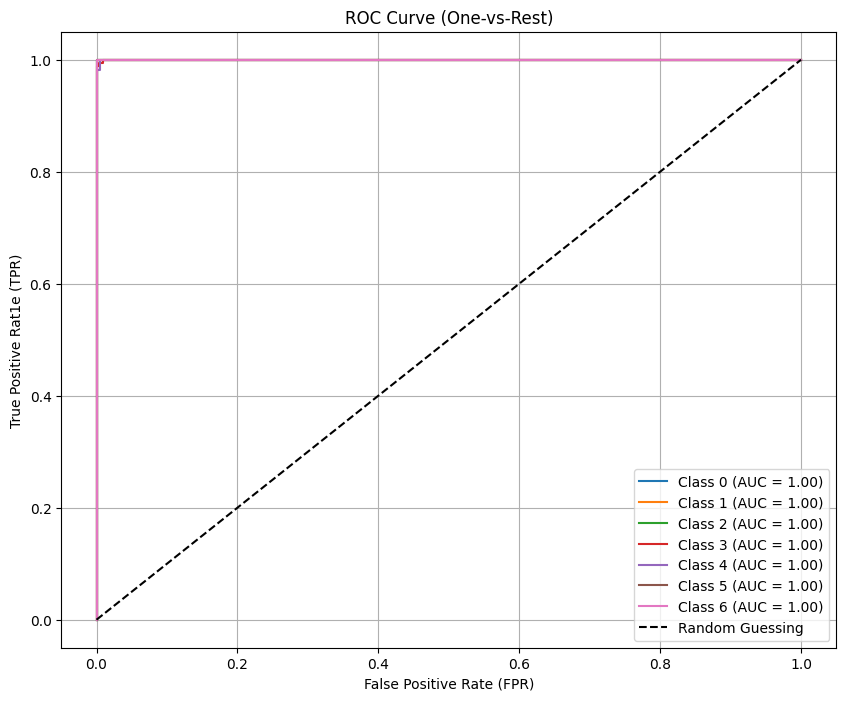

In [ ]:
plt.figure(figsize=(10, 8))

# Plot ROC for each class
for i in range(n_classes):
    plt.plot(
        fpr[i],
        tpr[i],
        label=f'Class {i} (AUC = {roc_auc[i]:.2f})'
    )

# Plot random guessing (diagonal line)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')

# Customize plot
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rat1e (TPR)')
plt.title('ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

perfect

# Deploy

In [25]:
def preprocess_image(image):
    # Convert to RGB if needed
    if image.mode != 'RGB':
        image = image.convert('RGB')

    # Resize to your model's expected input
    image = image.resize((img_size, img_size))  # img_size should be defined (e.g., 224)

    # Convert to array and preprocess
    image = img_to_array(image)
    image = preprocess_input_efficientnet(image)  # Same as used in training
    image = np.expand_dims(image, axis=0)  # Add batch dimension

    return image

def predict(image):
    processed_image = preprocess_image(image)
    predictions = loaded_model.predict(processed_image)
    predicted_class_idx = np.argmax(predictions[0])
    predicted_class = class_names[predicted_class_idx]
    confidence = predictions[0][predicted_class_idx]

    prediction_dict = {class_names[i]: float(predictions[0][i]) for i in range(len(class_names))}
    return prediction_dict, float(confidence)

# 5. Create Gradio interface
with gr.Blocks() as demo:
    gr.Markdown("# Teeth Disease Classification")

    with gr.Row():
        with gr.Column():
            image_input = gr.Image(type="pil", label="Upload Image")
            submit_btn = gr.Button("Classify")

        with gr.Column():
            label_output = gr.Label(label="Prediction", num_top_classes=3)
            # Optional: Add confidence score
            confidence_output = gr.Number(label="Top Confidence Score", precision=3)

    # Optional: Add examples
    examples = [["/content/Teeth_DataSet/Teeth_Dataset/Testing/CaS/a_100.jpg"], ["/content/Teeth_DataSet/Teeth_Dataset/Testing/CoS/b_100_0_7538.jpg"], ["/content/Teeth_DataSet/Teeth_Dataset/Testing/Gum/g_1200_0_2341.jpg"],['/content/Teeth_DataSet/Teeth_Dataset/Testing/MC/mc_1200_0_2464.jpg']]  # [CaS,CoS,Gum,MC]
    gr.Examples(examples=examples, inputs=image_input)

    # Connect the button
    submit_btn.click(
        fn=predict,
        inputs=image_input,
        outputs=[label_output, confidence_output]
    )

# 6. Launch the interface
demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://be5d1973d38640334c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
